In [1]:
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets, transforms

In [2]:
mnist_dataset = datasets.MNIST(root = './mnist_data',train=True,download=True)

In [3]:
data , target = mnist_dataset.data , mnist_dataset.targets

In [4]:
train_x, val_x, train_y, val_y = train_test_split(data,
                                                  target,
                                                  random_state =1234,
                                                  test_size=0.1,
                                                  stratify=target) #similar distribution for x and y

In [5]:
tranfs = transforms.Compose([
    transforms.Normalize((0.1307,),(0.3081))
])

In [6]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self,imgs,target, transform  = None):
        self.imgs = imgs
        self.target = target
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self,idx):
        img = self.imgs[idx].float() / 255
        img = img.unsqueeze(0)
        target = self.target[idx]
        
        if self.transform:
            img = self.transform(img)
            #dimensino (28,28) and needed is (1,28,28)
            
        return img,target

In [7]:
CustDat(train_x,train_y,tranfs)[0]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

In [8]:
train_dl = torch.utils.data.DataLoader(CustDat(train_x,train_y,tranfs),
                                      batch_size= 16,
                                      shuffle = True,
                                      num_workers = 0,
                                      pin_memory= True)

val_dl = torch.utils.data.DataLoader(CustDat(val_x,val_y,tranfs),
                                      batch_size= 16,
                                      shuffle = True,
                                      num_workers = 0,
                                      pin_memory= True)


In [9]:
#output = ( (input - kernelsize + 2*padding ) / stride ) +1
#           ( (28    -  3    + 2*1) / 1 ) +1  = 1 = 28 

In [12]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # batch of data will be 16 images of dimension (1,28,28)
        self.conv1 = nn.Conv2d(1,8,3,stride =1 , padding = 1) #size of img stays the same 
        # 16, 8,28,28, 
        self.maxpool1 = nn.MaxPool2d(2) # max pooling of kernel 2x2 , takes 2x2 and return 1 , so 1/4 remains
        # 16 , 8, 14 , 14 
        self.relu1 = nn.ReLU()
        # 16,8,14,14 
        self.conv2 = nn.Conv2d(8,16,3,stride =1 , padding = 1) #size of img stays the same 
        # 16, 16, 14,14
        self.maxpool2 = nn.MaxPool2d(2)
        # 16, 16, 7, 7 
        self.relu2 = nn.ReLU()
        # 16, 16, 7, 7 
        #flatten 
        # 16, 16*7*7
        self.fc = nn.Linear(16*7*7, 10) #photo of 16 channels , 7*7 dimensions
        # 16 * 10 
        
    def forward(self,x):
        out0 = self.conv1(x)
        out1 = self.maxpool1(out0)
        out2 = self.relu1(out1)
        out3 = self.conv2(out2)
        out4 = self.maxpool2(out3)
        out5 = self.relu2(out4)
        out6 = torch.flatten(out5, 1 ) # 1 says skip the 1st dimension and flatten all other dimensions
        out7 = self.fc(out6)
        return out7

In [13]:
model = Net()

In [15]:
loss_fn = nn.CrossEntropyLoss() # multiple class classification
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


In [17]:
num_epochs = 10 

train_loss = [] 
val_loss = []


for epoch in range(num_epochs):
    train_epoch_loss = 0
    val_epoch_loss = 0
    for data,target in train_dl:
        output = model(data)
        loss = loss_fn(output, target)
        train_epoch_loss += loss.detach().numpy()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    with torch.no_grad():
        for data,target in val_dl:
            output = model(data)
            loss = loss_fn(output, target)
            val_epoch_loss += loss.detach().numpy()
        
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    

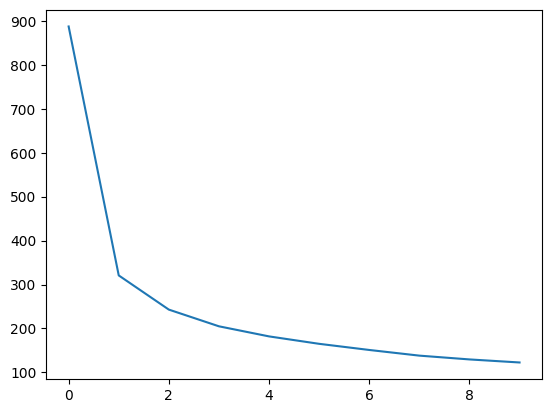

In [18]:
plt.plot(train_loss)


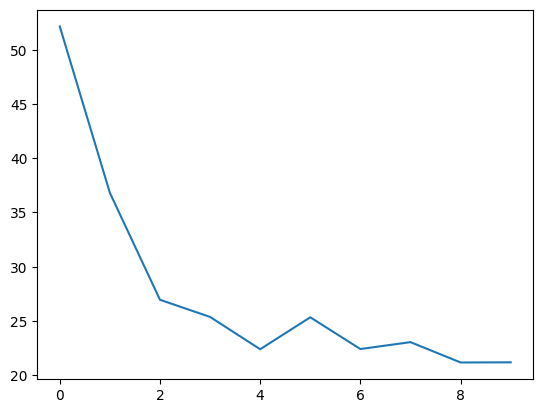

In [19]:
plt.plot(val_loss)

In [32]:
num = torch.randint(0, val_x.shape[0],(1,))

ig = val_x[num]
img = val_x[num][None , ...].float() / 255
targ = val_y[num]
model(tranfs(img)).argmax(), targ

(tensor(6), tensor([6]))

In [33]:
transforms.ToPILImage()(ig)